# pyMaBoSS

## A python interface for the MaBoSS software

In [1]:
import maboss, ginsim, biolqm

## Toy example

We are going to study this simple boolean network, where:
- A is constitutively activated
- B and C are activated by A
- B and C are mutually exclusive

#### Bnet file

In [2]:
!cat toy.bnet

A, 1
B, A & !C
C, A & !B


#### Showing the interaction graph with GINsim

In [3]:
g_model = biolqm.to_ginsim(biolqm.load("toy.bnet"))
ginsim.service("layout").runLayout(1, g_model)
ginsim.show(g_model)

### Creating the model

Now we want to have a MaBoSS model.
We need to write both a BND file, for the network, and a CFG file, for simulation settings.

#### BND file

This file defines the network : in the case of MaBoSS, its nodes, and rates to activate/inactivate them

In [4]:
!cat toy.bnd

node A {
    logic = 1;
    rate_up = @logic ? 1 : 0;
    rate_down = 0;
}

node B { 
    logic = A & !C;
    rate_up = @logic ? $act_B : 0;
    rate_down = 0;
}

node C { 
    logic = A & !B;
    rate_up = @logic ? $act_C : 0;
    rate_down = 0;
}
  

#### CFG file

This file defines the initial state of the network, parameter values, and simulation settings

In [5]:
!cat toy.cfg

A.istate = FALSE;
B.istate = FALSE;
C.istate = FALSE;

$act_B = 1;
$act_C = 1;

max_time = 20.0;
sample_count = 1000.0;
use_physrandgen = 1.0;
thread_count = 1.0;


#### We could have generated it using the bnet file and BioLQM

In [6]:
b_model = biolqm.load("toy.bnet")
m_model = biolqm.to_maboss(b_model)
m_model.print_bnd()

Node A {


	rate_up = $u_A;
	rate_down = 0;
}
Node B {

	logic = (A & !C);
	rate_up = @logic ? $u_B : 0;
	rate_down = @logic ? 0 : $d_B;
}

Node C {

	logic = (A & !B);
	rate_up = @logic ? $u_C : 0;
	rate_down = @logic ? 0 : $d_C;
}


In [7]:
m_model.print_cfg()

$nb_mutable = 0;
$u_A = 1;
$d_A = 1;
$u_B = 1;
$d_B = 1;
$u_C = 1;
$d_C = 1;
A.istate = FALSE;
B.istate = FALSE;
C.istate = FALSE;

time_tick = 0.5;
max_time = 1000.0;
sample_count = 10000.0;
discrete_time = 0.0;
use_physrandgen = 1.0;
seed_pseudorandom = 0.0;
display_traj = 0.0;
statdist_traj_count = 0.0;
statdist_cluster_threshold = 1.0;
thread_count = 1.0;
statdist_similarity_cache_max_size = 20000.0;
A.is_internal = False;
B.is_internal = False;
C.is_internal = False;



Conversion through GINsim/BioLQM also works with SBML-Qual models, making it compatible with model from CaSQ, BioModels, Cell Collective, ...

### Simulating the model

First we load the model

In [8]:
model = maboss.load("toy.bnd", "toy.cfg")

Then we run the simulation

In [9]:
res = model.run()

#### Plotting the results

This example is a simple fork : with asynchronous update and with default parameters, what should the results be ?

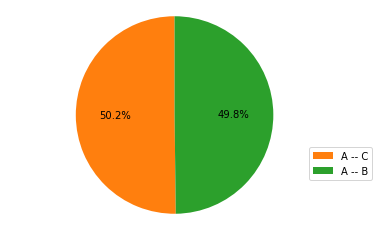

In [10]:
res.plot_piechart()

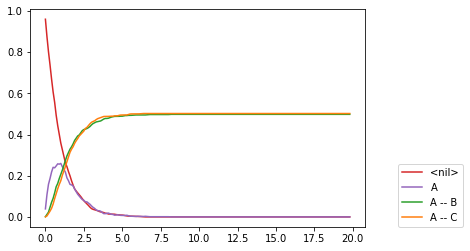

In [11]:
res.plot_trajectory()

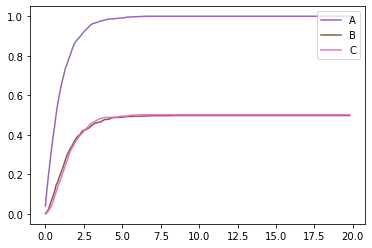

In [12]:
res.plot_node_trajectory()

#### Getting trajectory data

We can get both state and node probability trajectories, as panda dataframes

In [13]:
table = res.get_states_probtraj()
table

,<nil>,A,A -- B,A -- C
0.0,0.959660,0.039038,0.000886,0.000416
0.1,0.875274,0.107857,0.012149,0.004720
0.2,0.801390,0.158588,0.023300,0.016723
0.3,0.737802,0.186609,0.047500,0.028089
0.4,0.669404,0.217805,0.070970,0.041821
...,...,...,...,...
19.4,0.000000,0.000000,0.498000,0.502000
19.5,0.000000,0.000000,0.498000,0.502000
19.6,0.000000,0.000000,0.498000,0.502000
19.7,0.000000,0.000000,0.498000,0.502000


In [14]:
table_nodes = res.get_nodes_probtraj()
table_nodes

,A,B,C
0.0,0.040340,0.000886,0.000416
0.1,0.124726,0.012149,0.004720
0.2,0.198611,0.023300,0.016723
0.3,0.262198,0.047500,0.028089
0.4,0.330596,0.070970,0.041821
...,...,...,...
19.4,1.000000,0.498000,0.502000
19.5,1.000000,0.498000,0.502000
19.6,1.000000,0.498000,0.502000
19.7,1.000000,0.498000,0.502000


<AxesSubplot:>

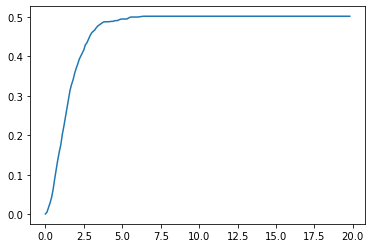

In [15]:
table_nodes["C"].plot()

### Modifying the simulation

#### Modifying initial states

In [16]:
model2 = model.copy()
model2.network.set_istate('C', [0.25, 0.75]) # 75% of cells will have C active

In [17]:
model2.print_cfg()

$nb_mutable = 0;
$act_B = 1;
$act_C = 1;
A.istate = FALSE;
B.istate = FALSE;
[C].istate = 0.25[0] , 0.75[1];

time_tick = 0.1;
max_time = 20.0;
sample_count = 1000.0;
discrete_time = 0;
use_physrandgen = 1.0;
seed_pseudorandom = 0;
display_traj = 0;
statdist_traj_count = 0;
statdist_cluster_threshold = 1;
thread_count = 1.0;
statdist_similarity_cache_max_size = 20000;
A.is_internal = False;
B.is_internal = False;
C.is_internal = False;



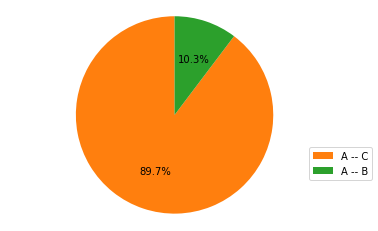

In [18]:
res2 = model2.run()
res2.plot_piechart()

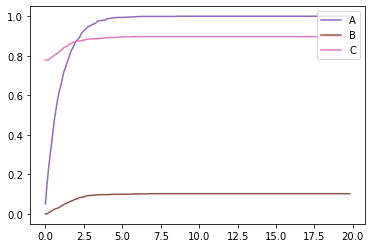

In [19]:
res2.plot_node_trajectory()

#### Modifying rate parameters

In [20]:
model3 = model.copy()
model3.param["$act_B"] = 10

We modified the configuration of the simulation

In [21]:
model3.print_cfg()

$nb_mutable = 0;
$act_B = 10;
$act_C = 1;
A.istate = FALSE;
B.istate = FALSE;
C.istate = FALSE;

time_tick = 0.1;
max_time = 20.0;
sample_count = 1000.0;
discrete_time = 0;
use_physrandgen = 1.0;
seed_pseudorandom = 0;
display_traj = 0;
statdist_traj_count = 0;
statdist_cluster_threshold = 1;
thread_count = 1.0;
statdist_similarity_cache_max_size = 20000;
A.is_internal = False;
B.is_internal = False;
C.is_internal = False;



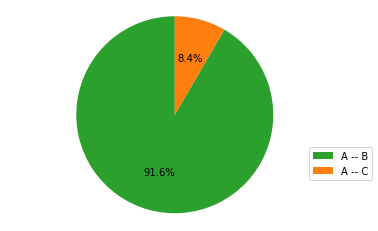

In [22]:
res3 = model3.run()
res3.plot_piechart()

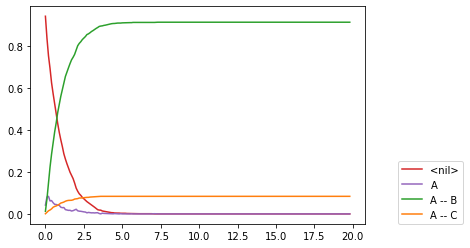

In [23]:
res3.plot_trajectory()

#### Mutating the network

In [24]:
model4 = model.copy()
model4.mutate('C', 'OFF')

In [25]:
model4.print_bnd()

Node A {

	logic = 1;
	rate_up = @logic ? 1 : 0;
	rate_down = 0;
}
Node B {

	logic = A & !C;
	rate_up = @logic ? $act_B : 0;
	rate_down = 0;
}

Node C {

	logic = A & !B;
	rate_up = $Low_C ? 0 : ($High_C ? 1E308/$nb_mutable : (@logic ? $act_C : 0));
	rate_down = $High_C ? 0 : ($Low_C ? 1E308/$nb_mutable : (0));
}


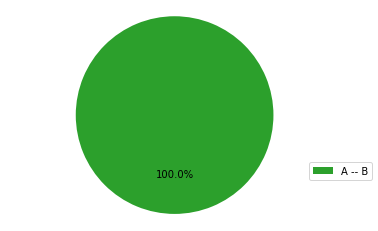

In [26]:
res4 = model4.run()
res4.plot_piechart()

#### Reducing state combinatorials

In [27]:
model5 = model.copy()
model5.network.set_output(["B", "C"])

In [28]:
model5.print_cfg()

$nb_mutable = 0;
$act_B = 1;
$act_C = 1;
A.istate = FALSE;
B.istate = FALSE;
C.istate = FALSE;

time_tick = 0.1;
max_time = 20.0;
sample_count = 1000.0;
discrete_time = 0;
use_physrandgen = 1.0;
seed_pseudorandom = 0;
display_traj = 0;
statdist_traj_count = 0;
statdist_cluster_threshold = 1;
thread_count = 1.0;
statdist_similarity_cache_max_size = 20000;
A.is_internal = True;
B.is_internal = False;
C.is_internal = False;



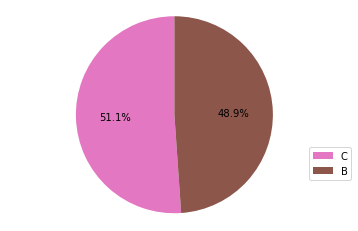

In [29]:
res5 = model5.run()
res5.plot_piechart()

## Population toy example

#### Creating Death and Division nodes

In [30]:
model6 = model.copy()
model6.param["max_time"] = 5

model6.network.add_node("Death")
model6.network["Death"].rt_up = "0";
model6.network["Death"].rt_down = "0";
model6.network.set_istate('Death', [1, 0])

In [31]:
model6.network.add_node("Division")
model6.network["Division"].rt_up = "C ? 0.01 : 0.001"
model6.network["Division"].rt_down = 0; 
model6.network.set_istate('Division', [1, 0])

#### Building the UPMaBoSS simulation

In [32]:
pop_model = maboss.UpdatePopulation(model6)

In [33]:
pop_model.setDeathNode("Death")
pop_model.setDivisionNode("Division")
pop_model.setStepNumber(20)

#### Running the simulation

In [34]:
pop_res = pop_model.run()

#### Plotting the population dynamics

<AxesSubplot:>

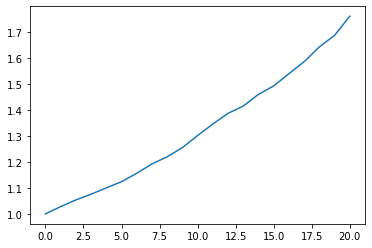

In [35]:
pop_res.get_stepwise_probability_distribution().iloc[:, 0].plot()

#### Plotting the state distributions

<AxesSubplot:>

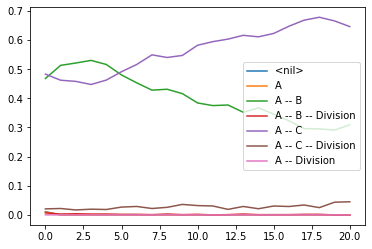

In [36]:
pop_res.get_stepwise_probability_distribution().iloc[:, 1:].plot()

### Adding cell-cell interactions

In [37]:
model7 = model6.copy()

We create a $death_rate parameter

In [38]:
model7.param["$death_rate"] = 0

This parameter will control the activation rate of the Death node, but only for C cells

In [39]:
model7.network["Death"].rt_up = "C ? $death_rate*0.1 : 0"

In [40]:
pop_model2 = maboss.UpdatePopulation(model7)

This time we also set an external variable, which depends on the percentage of B cells, to update the death rate.

In [41]:
pop_model2.setDeathNode("Death")
pop_model2.setDivisionNode("Division")
pop_model2.setStepNumber(100)
pop_model2.setExternalVariable("$death_rate", "p[(B) = (1)]")

So to summarize, B cells will activate the death of C cells.

In [42]:
pop_res2 = pop_model2.run()

#### Plotting the population dynamics

<AxesSubplot:>

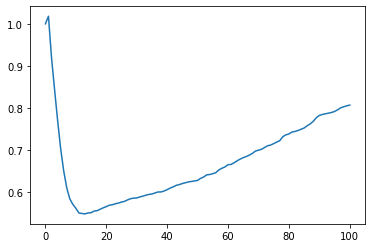

In [43]:
pop_res2.get_stepwise_probability_distribution().iloc[:, 0].plot()

This time, the population initially increases then drops

#### Plotting state distribution

<AxesSubplot:>

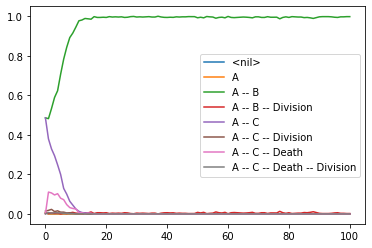

In [44]:
pop_res2.get_stepwise_probability_distribution().iloc[:, 1:].plot()

C cells are being killed by B cells, which become dominant